This script compares the TADs and the genes therein in human and axolotl and outputs the TADs that a similar
in terms of the contained genes

In [36]:
opts_hg19 = ['/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/hg19.annotation.gtf', 
             '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/compare_TADs/hg19.TADs.merged_100kb.bed']
opts_amex = ['/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/AmexT_v47.FULL.gtf', 
             '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/compare_TADs/ambMex60DD.TADs.merged_100kb.bed']
opts_out =  ['/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/compare_TADs/homologous_TADs.hg19_vs_amex.list']
opts_tadsout = ['/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/homologous_TADs.list']

In [37]:
import pandas as pd
import os
import sys
import re

def loadGenes(gtfFile):
    genes = []
    with(open(gtfFile, 'r')) as hFile:
        for line in hFile.readlines():
            if line.startswith('#'):
                continue
            chrName, _, entryType, start, end, _, strand, _, attr = line.split('\t')
            if entryType != 'gene' or not chrName.startswith('chr'):
                continue
            m = re.search('gene_type "protein_coding";.+; gene_name "([^"]+)"', attr)
            if m:
                genes.append([chrName, int(start), int(end), m.group(1)])
            else:
                m = re.search('gene_id "AMEX60.+; gene_name "([^"]+)"', attr)
                if m:
                    for symbol in m.group(1).split('|'):
                        if not symbol.startswith('AMEX'):
                            if symbol.endswith('.L') or symbol.endswith('.S'):
                                symbol = symbol[:-2]
                            genes.append([chrName, int(start), int(end), symbol.replace(' [nr]', '').replace(' [hs]', '')])
    return pd.DataFrame(data=genes, columns=['chr', 'start', 'end', 'symbol'])


def loadTADs(bedFile):
    data = []
    with(open(bedFile, 'r')) as hFile:
        for line in hFile.readlines():
            if line.startswith('#'):
                continue
            chrName, start, end, _ = line.split('\t', 3)
            data.append([chrName, int(start), int(end)])
    return pd.DataFrame(data=data, columns=['chr', 'start', 'end'])


In [38]:
print(f"Reading the human TADs from '{opts_hg19[1]}'", file=sys.stderr)
tads_hg = loadTADs(opts_hg19[1])
print(f"Reading the human genes from '{opts_hg19[0]}'", file=sys.stderr)
genes_hg = loadGenes(opts_hg19[0])
print(f'  Loaded {genes_hg["chr"].count()} genes in {tads_hg["chr"].count()} TADs', file=sys.stderr)

print(f"Reading the axolotl TADs from '{opts_amex[1]}'", file=sys.stderr)
tads_amex = loadTADs(opts_amex[1])
print(f"Reading the axolotl genes from '{opts_amex[0]}'", file=sys.stderr)
genes_amex = loadGenes(opts_amex[0])
print(f'  Loaded {genes_amex["chr"].count()} genes in {tads_amex["chr"].count()} TADs', file=sys.stderr)

Reading the human TADs from '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/compare_TADs/hg19.TADs.merged_100kb.bed'
Reading the human genes from '/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/hg19.annotation.gtf'
  Loaded 20345 genes in 12918 TADs
Reading the axolotl TADs from '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/compare_TADs/ambMex60DD.TADs.merged_100kb.bed'
Reading the axolotl genes from '/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/AmexT_v47.FULL.gtf'
  Loaded 38160 genes in 37551 TADs


In [39]:
hOut = open(opts_out[0], 'w')
processed = set()
nNoTADs = 0
nNoHits = 0
nHomologous = 0
lengths = {'hg': [], 'amex': []}
for symbol in list(set(genes_hg['symbol'].values)):
    if symbol in processed:
        continue
    
    # Select all human genes that have the current gene symbol. Since there are quite a few cases
    # where two genes are annotated with the same gene symbol and basically the same position,
    # pick the first one.
    [[geneChr_hg, geneStart_hg, geneEnd_hg, _]] = genes_hg[genes_hg['symbol'] == symbol].head(1).values
    
    # Next, find the smallest TAD in the human genome that contains the gene
    _tads_hg = tads_hg[(tads_hg['chr'] == geneChr_hg) & (tads_hg['start'] <= geneStart_hg) & (tads_hg['end'] >= geneEnd_hg)]
    if _tads_hg['chr'].count() == 0:
        nNoTADs += 1
        continue
    
    _mintadlen_hg = pd.DataFrame.min(_tads_hg['end'] - _tads_hg['start'])
    _hg_tad = _tads_hg[_tads_hg['end'] - _tads_hg['start'] == _mintadlen_hg].head(1)

    [[chrTAD_hg, startTAD_hg, endTAD_hg]] = _hg_tad.values
        
    # Find the human genes within that TAD
    _genes_hg = genes_hg[ (genes_hg['chr'] == chrTAD_hg) & 
                          (genes_hg['start'].between(startTAD_hg, endTAD_hg) | genes_hg['end'].between(startTAD_hg, endTAD_hg)) ]
    
    # Find the axolotl counterparts of the genes within the TAD
    _genes_amex = genes_amex[genes_amex['symbol'].isin(_genes_hg['symbol'].values)]
    
    # Find all TADs in axolotl that contain the genes identified above
    _tads_amex = pd.DataFrame(columns=['chr', 'start', 'end'])
    for idx in _genes_amex.index:
        tmp = tads_amex[ (tads_amex['chr'] == _genes_amex['chr'][idx]) & 
                         (tads_amex['start'] <= _genes_amex['start'][idx]) & 
                         (tads_amex['end'] >= _genes_amex['end'][idx])]
        tmp['symbol'] = _genes_amex['symbol'][idx]
        _tads_amex = pd.concat([_tads_amex, tmp])
        
    if _tads_amex['chr'].count() == 0:
        nNoHits += 1
    else:
        
        # Find the smallest TAD that includes the majority of the genes
        #_mintadlen_amex = pd.DataFrame.min(tmp['end'] - tmp['start'])
        #tmp = tmp[tmp['end'] - tmp['start'] == _mintadlen_amex].head(1)
        
        # Find the TADs with the highest number of genes in them.
        gene_counts = _tads_amex.drop_duplicates().groupby(['chr', 'start', 'end']).count()
        mxN = pd.DataFrame.max(gene_counts['symbol'])
        tmp = gene_counts[gene_counts['symbol'] == mxN].reset_index()
        
        _mintadlen_amex = pd.DataFrame.min(tmp['end'] - tmp['start'])
        _amex_tad = tmp[tmp['end'] - tmp['start'] == _mintadlen_amex].head(1)
        lengths['hg'].append([_mintadlen_hg, sorted(list(set(_genes_hg['symbol'].values)))])
        lengths['amex'].append([_mintadlen_amex, sorted(list(set(_genes_amex['symbol'].values)))])
        nHomologous += 1
        
        print(f"{_hg_tad['chr'].values[0]}:{_hg_tad['start'].values[0]}-{_hg_tad['end'].values[0]}\t" + 
              f"{sorted(list(set(_genes_hg['symbol'].values)))}\t" + 
              f"{_amex_tad['chr'].values[0]}:{_amex_tad['start'].values[0]}-{_amex_tad['end'].values[0]}\t" +
              f"{sorted(list(set(_genes_amex['symbol'].values)))}", file=hOut)

    for s in _genes_hg['symbol'].values:
        processed.add(s)

print(f"Analyzed {genes_hg['symbol'].count()} human genes. " + 
      f'For {nNoTADs}, no TAD could be found. ' +
      f'{nNoHits} TADs did not have axolotl hits', file=sys.stderr)
hOut.close()

<ipython-input-39-e5663ae44d37>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['symbol'] = _genes_amex['symbol'][idx]
Analyzed 20345 human genes. For 3830, no TAD could be found. 292 TADs did not have axolotl hits


(0.0, 50.0)

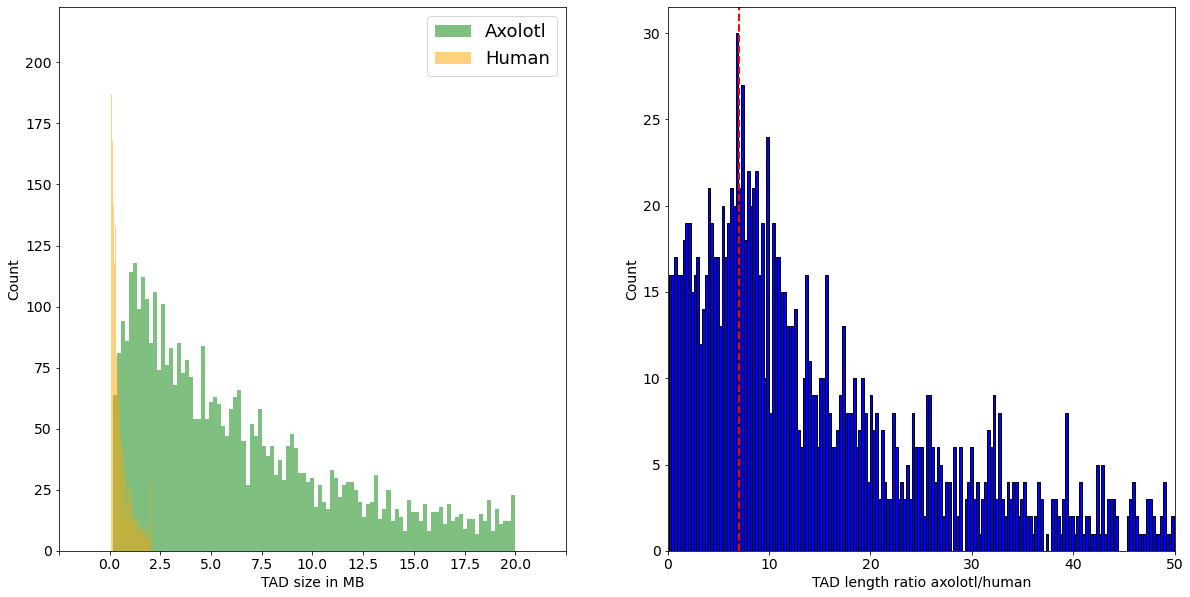

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import statistics as stats
import math

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axs[0].hist([x[0] for x in lengths['amex']], bins=100, color='green', label='Axolotl', alpha=0.5)
axs[0].hist([x[0] for x in lengths['hg']], bins=100, color='orange', label='Human', alpha=0.5)
axs[0].legend(fontsize=18)
plt.sca(axs[0])
xticks, xlabels = plt.xticks()
xlabels_new = []
for x in xticks:
    xlabels_new.append(f'{x / 1000_000:.1f}')
xlabels_new[0] = ''
xlabels_new[-1] = ''
plt.xticks(xticks, xlabels_new, fontsize=14)
plt.xlabel('TAD size in MB', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.setp(axs[0].get_yticklabels(), fontsize=14)

ratios = []
nIsNan = 0
idx = 1
#hOutTADs = open(opts_tadsout[0], 'w')
#print('Index\tHuman TAD length\tHuman genes count\tHuman genes\tAxolotl TAD length\tAxolotl genes count\tAxolotl genes\t1:1 homolog', file=hOutTADs)
for hg, am in zip(lengths['hg'], lengths['amex']):
    str1_1 = 'NO'
    if len(am[1]) == len(hg[1]):
        str1_1 = 'YES'
        ratios.append(am[0] / hg[0])
    #print(f'{idx}\t{hg[0]}\t{len(hg[1])}\t{hg[1]}\t{am[0]}\t{len(am[1])}\t{am[1]}\t{str1_1}', file=hOutTADs)
    #idx += 1
    #if 'FGF8' in hg[1]:
    #    print(f'{hg}\t{am}')
hOutTADs.close()
    
axs[1].hist(ratios, bins=1000, color='blue', edgecolor='black')
axs[1].axvline(7, linestyle='dashed', color='red', linewidth=2)
plt.setp(axs[1].get_xticklabels(), fontsize=14)
plt.setp(axs[1].get_yticklabels(), fontsize=14)
plt.sca(axs[1])
plt.xlabel('TAD length ratio axolotl/human', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim([0, 50])

In [35]:
len(ratios)

1680